<a href="https://colab.research.google.com/github/M-ballabio1/DataScience_ML_DL-projects/blob/main/DataScienceProjects/4.Sarima_model%20-%20Quality%20Air%20dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### SARIMA

In [2]:
pip install pmdarima

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import pandas as pd
%matplotlib inline 
import matplotlib.pyplot as plt
import statsmodels as sm
import seaborn as sns
from pmdarima.arima import ARIMA
from pmdarima.arima import auto_arima

import warnings 
warnings.filterwarnings("ignore")

In [4]:
from google.colab import files 

df = files.upload()

Saving Dataset_AQ.xlsx to Dataset_AQ (1).xlsx


In [5]:
df = pd.read_excel('Dataset_AQ.xlsx')
print(df)


                     Date  BlackCarbon  ...  Relative_humidity  Temperature
0    2014-01-05T23:00:00Z     4.940000  ...          88.612927     2.569692
1    2014-01-12T23:00:00Z     7.240000  ...          83.934511     5.487934
2    2014-01-19T23:00:00Z     4.585714  ...          91.254229     3.020901
3    2014-01-26T23:00:00Z     5.500000  ...          74.341920     4.766052
4    2014-02-02T23:00:00Z     3.642857  ...          87.962498     2.564018
..                    ...          ...  ...                ...          ...
308  2019-12-01T23:00:00Z     3.466667  ...          87.507713     6.633415
309  2019-12-08T23:00:00Z     2.850000  ...          78.335394     3.547048
310  2019-12-15T23:00:00Z     2.980000  ...          76.884068     2.499465
311  2019-12-22T23:00:00Z     3.557143  ...          94.809078     6.673679
312  2019-12-29T23:00:00Z     3.233333  ...          66.618533     4.163620

[313 rows x 11 columns]


In [6]:
df['Date'] = pd.to_datetime(df['Date'])

Come notiamo i dati sono di tipo settimanale.

In [7]:
df

,Date,BlackCarbon,Carbon_Monoxide,Nitric_Oxigen,Nitrogen_Dioxide,Other,Ozone,PM10,PM2.5,Relative_humidity,Temperature
0,2014-01-05 23:00:00+00:00,4.940000,1.131926,86.343883,39.274285,3.079632,10.433822,39.816493,35.867097,88.612927,2.569692
1,2014-01-12 23:00:00+00:00,7.240000,1.262728,137.552704,44.407672,3.771451,8.085711,54.147144,42.487306,83.934511,5.487934
2,2014-01-19 23:00:00+00:00,4.585714,1.069887,104.035676,41.050989,3.183397,8.994553,31.279041,24.851380,91.254229,3.020901
3,2014-01-26 23:00:00+00:00,5.500000,0.980521,125.212004,43.558825,3.610101,16.541452,36.914636,27.714028,74.341920,4.766052
4,2014-02-02 23:00:00+00:00,3.642857,0.930767,91.325346,42.979772,3.125399,14.782626,36.176093,29.548442,87.962498,2.564018
...,...,...,...,...,...,...,...,...,...,...,...
308,2019-12-01 23:00:00+00:00,3.466667,0.714729,78.893047,32.958568,2.662906,11.360726,25.628122,19.451488,87.507713,6.633415
309,2019-12-08 23:00:00+00:00,2.850000,0.846985,106.568574,41.274109,2.987834,12.406892,40.740306,32.548546,78.335394,3.547048
310,2019-12-15 23:00:00+00:00,2.980000,0.825581,99.064946,44.437904,3.141001,15.285071,36.579938,30.130722,76.884068,2.499465
311,2019-12-22 23:00:00+00:00,3.557143,0.840518,95.077217,35.146074,2.861242,13.521588,29.002498,22.205184,94.809078,6.673679


In [8]:
df.describe()

,BlackCarbon,Carbon_Monoxide,Nitric_Oxigen,Nitrogen_Dioxide,Other,Ozone,PM10,PM2.5,Relative_humidity,Temperature
count,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000
mean,2.598477,0.585677,59.354691,30.653090,3.062523,48.705469,30.786863,22.809449,72.737167,12.191685
std,1.743289,0.242372,39.534197,11.165462,0.521420,29.228117,14.680698,12.528847,10.102477,7.211864
min,0.700000,0.290381,15.816408,12.648937,1.912743,6.208993,11.451261,7.725092,44.345374,-1.487782
25%,1.292857,0.397454,29.124295,21.239814,2.667040,20.316208,19.179523,13.131349,65.899244,5.487934
50%,1.978571,0.492334,42.924635,28.182365,3.061556,47.811962,27.073591,18.796536,73.394709,12.131573
75%,3.400000,0.760771,82.772673,39.724326,3.411775,71.211267,38.198325,29.921234,79.059156,18.537600
max,9.785714,1.354504,203.930299,63.515094,4.702102,119.455520,90.997589,72.621443,95.285244,26.290979


In [9]:
#Conta i valori nulli
df.isnull().value_counts()

Date   BlackCarbon  Carbon_Monoxide  Nitric_Oxigen  Nitrogen_Dioxide  Other  Ozone  PM10   PM2.5  Relative_humidity  Temperature
False  False        False            False          False             False  False  False  False  False              False          313
dtype: int64

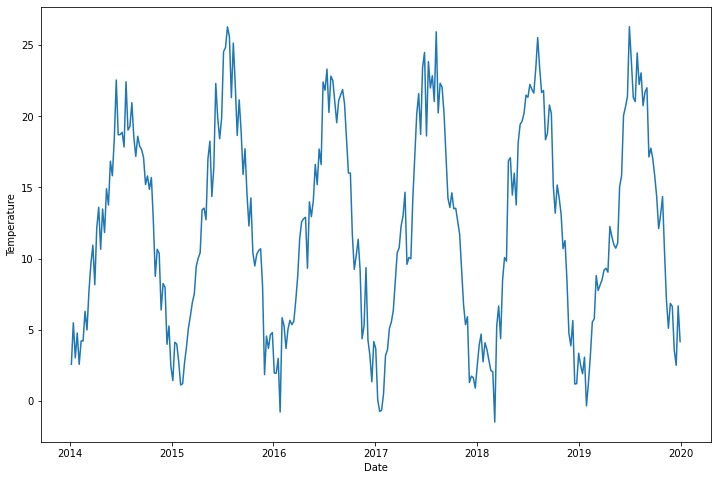

In [10]:
#Plot --> noto estrema stagionalità sulla Temperatura chiaramente
plt.figure(figsize=(12,8))
sns.lineplot(data=df, x='Date', y= 'Temperature')

In [11]:
X = df.drop(['Date','Temperature'], axis=1)
X

,BlackCarbon,Carbon_Monoxide,Nitric_Oxigen,Nitrogen_Dioxide,Other,Ozone,PM10,PM2.5,Relative_humidity
0,4.940000,1.131926,86.343883,39.274285,3.079632,10.433822,39.816493,35.867097,88.612927
1,7.240000,1.262728,137.552704,44.407672,3.771451,8.085711,54.147144,42.487306,83.934511
2,4.585714,1.069887,104.035676,41.050989,3.183397,8.994553,31.279041,24.851380,91.254229
3,5.500000,0.980521,125.212004,43.558825,3.610101,16.541452,36.914636,27.714028,74.341920
4,3.642857,0.930767,91.325346,42.979772,3.125399,14.782626,36.176093,29.548442,87.962498
...,...,...,...,...,...,...,...,...,...
308,3.466667,0.714729,78.893047,32.958568,2.662906,11.360726,25.628122,19.451488,87.507713
309,2.850000,0.846985,106.568574,41.274109,2.987834,12.406892,40.740306,32.548546,78.335394
310,2.980000,0.825581,99.064946,44.437904,3.141001,15.285071,36.579938,30.130722,76.884068
311,3.557143,0.840518,95.077217,35.146074,2.861242,13.521588,29.002498,22.205184,94.809078


In [12]:
Y = df.iloc[:,10]
Y

0      2.569692
1      5.487934
2      3.020901
3      4.766052
4      2.564018
         ...   
308    6.633415
309    3.547048
310    2.499465
311    6.673679
312    4.163620
Name: Temperature, Length: 313, dtype: float64

In [13]:
#Testing for stationarity for Volume  --> Troviamo che è stazionario in quanto p-value << 0.05
from pmdarima.arima import ADFTest
from statsmodels.tsa.stattools import adfuller

result = adfuller(df.iloc[:,10])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.304691
p-value: 0.000000
Critical Values:
	1%: -3.453
	5%: -2.871
	10%: -2.572


In [14]:
from statsmodels.tsa.stattools import kpss

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c")
    kpss_output = pd.Series(kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"])
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)
    
kpss_test(df['Temperature'].values)

Results of KPSS Test:
Test Statistic            0.027627
p-value                   0.100000
Lags Used                10.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


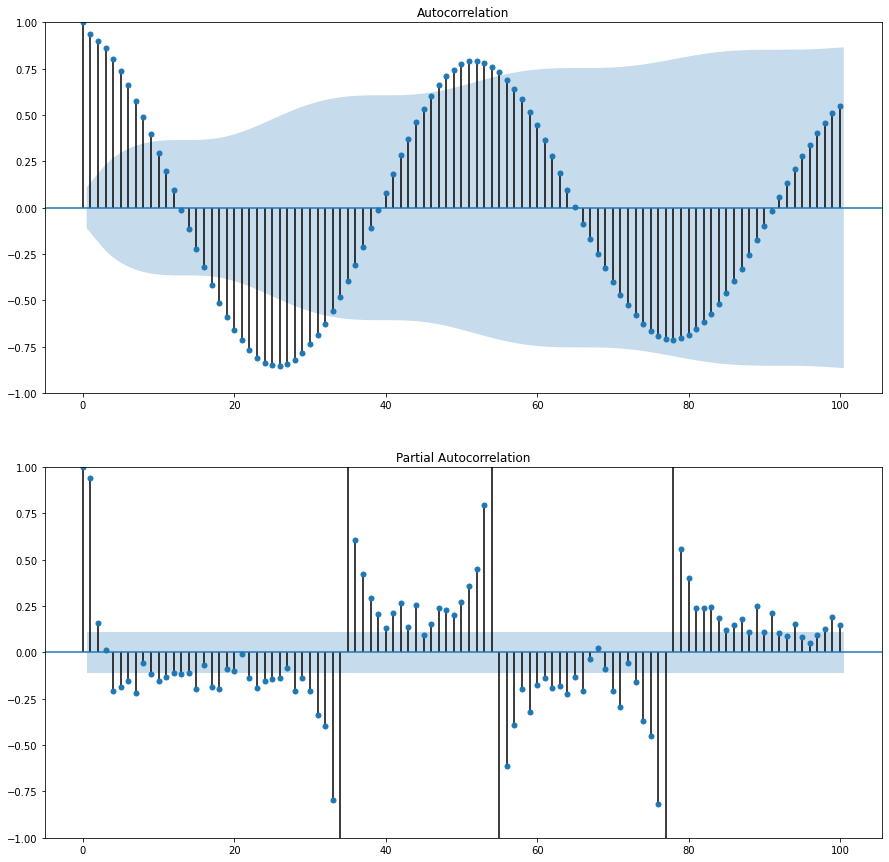

In [15]:
import statsmodels.api as sm

fig, ax = plt.subplots(2,1, figsize=(15,15))
fig = sm.graphics.tsa.plot_acf(Y, lags=100, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(Y, lags=100, ax=ax[1])
plt.show()

### Feature Engineering

Siccome i dati settimanali sono molto variabile, ho modificato i dati andando a lavorare sulle medie mobili (finestra=3) dei dati iniziali.

In [16]:
time = df['Date']
time

0     2014-01-05 23:00:00+00:00
1     2014-01-12 23:00:00+00:00
2     2014-01-19 23:00:00+00:00
3     2014-01-26 23:00:00+00:00
4     2014-02-02 23:00:00+00:00
                 ...           
308   2019-12-01 23:00:00+00:00
309   2019-12-08 23:00:00+00:00
310   2019-12-15 23:00:00+00:00
311   2019-12-22 23:00:00+00:00
312   2019-12-29 23:00:00+00:00
Name: Date, Length: 313, dtype: datetime64[ns, UTC]

0         NaN
1         NaN
2    3.692842
3    4.424962
4    3.450324
5    3.847789
6    3.662118
7    4.905156
8    5.162313
9    6.327332
Name: Temperature, dtype: float64


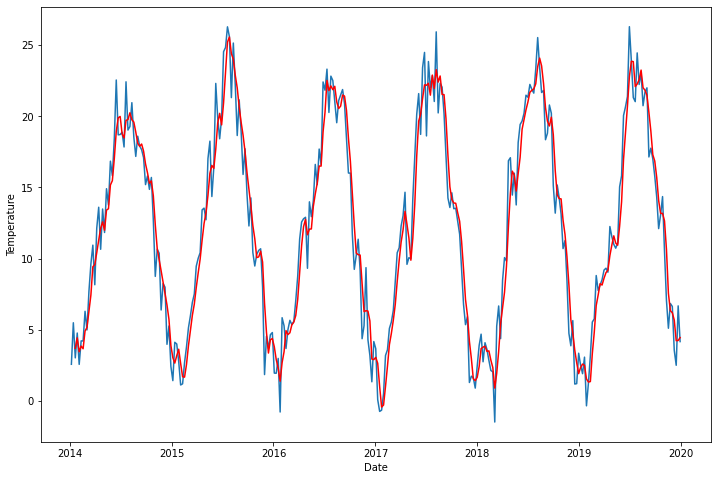

In [17]:
# Tail-rolling average transform
rolling = Y.rolling(window=3)
rolling_mean_temp = rolling.mean()
print(rolling_mean_temp.head(10))
# plot original and transformed dataset
plt.figure(figsize=(12,8))
sns.lineplot(data=df, x='Date', y= Y)
sns.lineplot(data=df, x='Date', y= rolling_mean_temp , color='red')

In [18]:
rolling_mean_temp.drop(df.head(2).index, inplace=True)

In [19]:
rolling_mean_temp

2      3.692842
3      4.424962
4      3.450324
5      3.847789
6      3.662118
         ...   
308    6.192714
309    5.674575
310    4.226643
311    4.240064
312    4.445588
Name: Temperature, Length: 311, dtype: float64

In [20]:
rolling_mean_temp.shape

(311,)

In [195]:
#Spliting the dataset into train (>95%) and test (ultimi 3 days)
train = rolling_mean_temp[:301]
test = rolling_mean_temp[-11:]
train

2       3.692842
3       4.424962
4       3.450324
5       3.847789
6       3.662118
         ...    
298    17.299332
299    16.851748
300    15.709496
301    14.075834
302    13.167489
Name: Temperature, Length: 301, dtype: float64

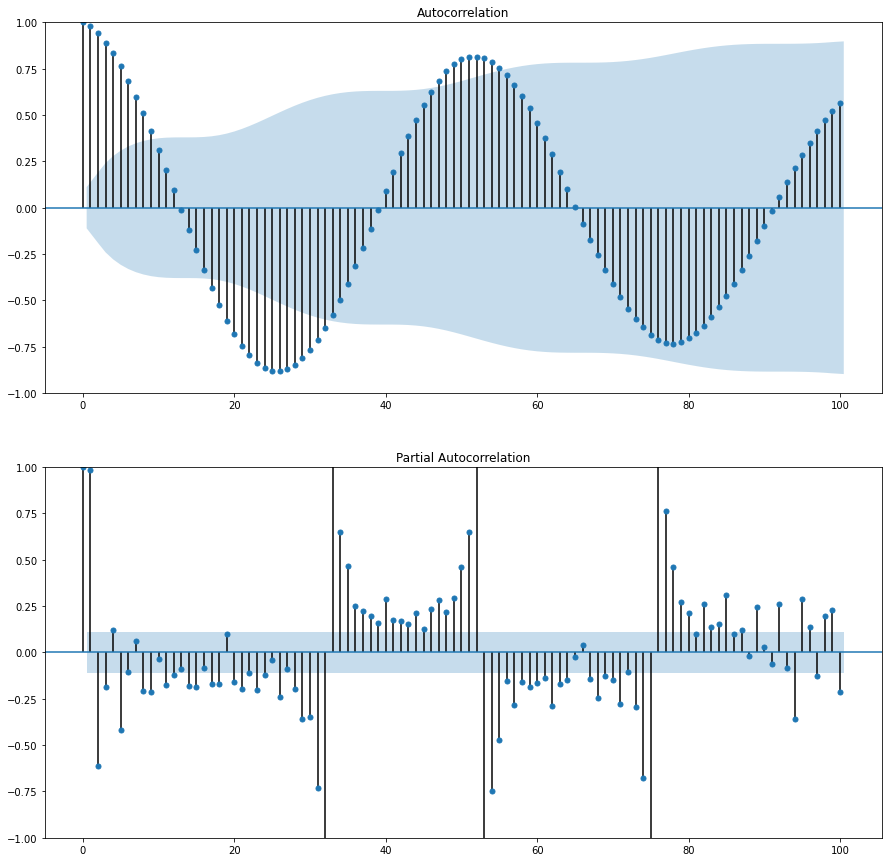

In [193]:
import statsmodels.api as sm

fig, ax = plt.subplots(2,1, figsize=(15,15))
fig = sm.graphics.tsa.plot_acf(rolling_mean_temp, lags=100, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(rolling_mean_temp, lags=100, ax=ax[1])
plt.show()

Text(0, 0.5, 'Temperature')

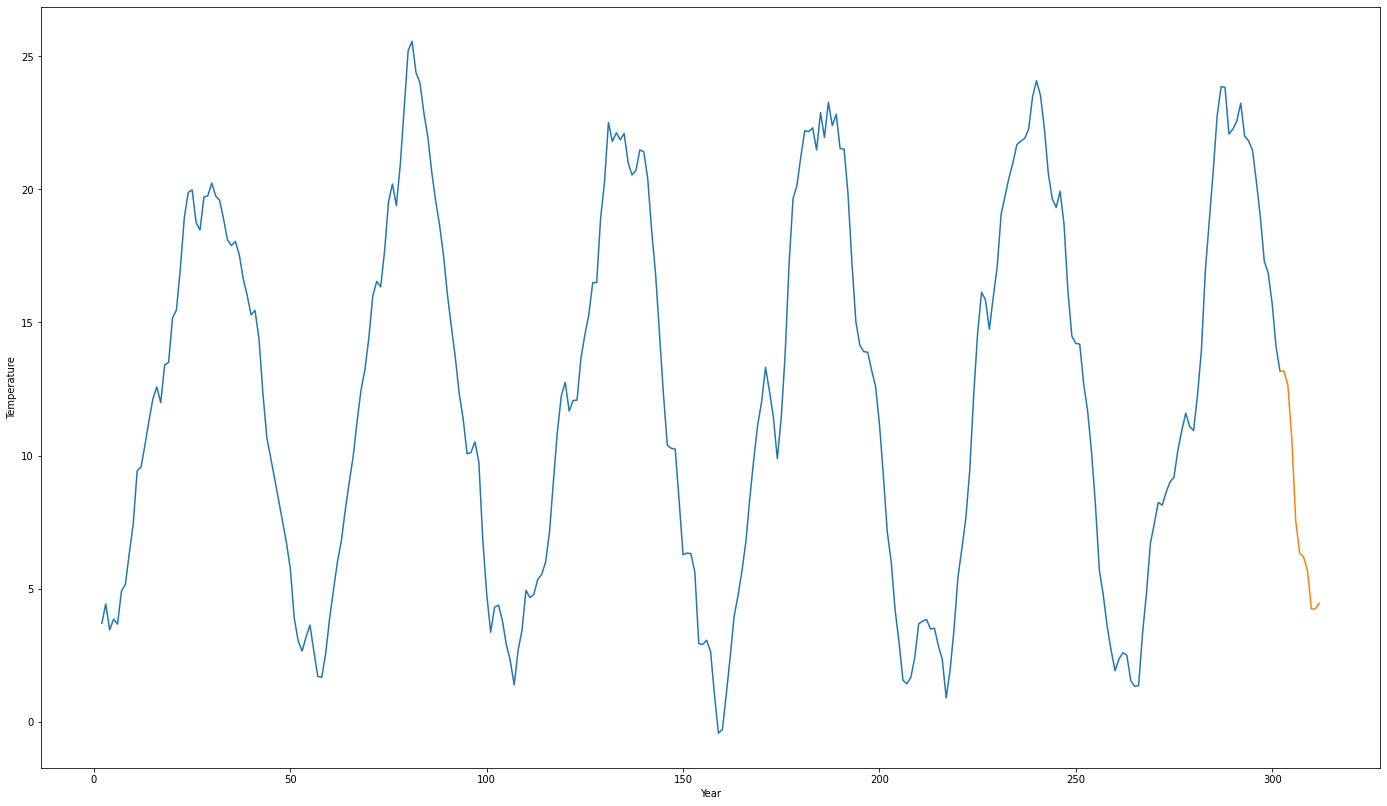

In [244]:
plt.figure(figsize=(24,14))
plt.plot(train)
plt.plot(test)
plt.xlabel('Year')
plt.ylabel('Temperature')

In [157]:
from statsmodels.tsa.statespace.sarimax import SARIMAX          # Per la modellazione della time series

## **SCELTA DEL MODELLO OTTIMO**

#### **SARIMA ( p, d, q )(P, D, Q)[m]**

**Il parametro p** è il numero di termini autoregressivi o il numero di "osservazioni in ritardo". Viene anche chiamato "ordine di ritardo" e determina il risultato del modello fornendo punti dati ritardati.

**Il parametro d** è noto come grado di differenziazione. indica il numero di volte in cui gli indicatori ritardati sono stati sottratti per rendere stazionari i dati.

**Il parametro q** è il numero di errori di previsione nel modello ed è indicato anche come la dimensione della finestra della media mobile.

**P: Seasonal autoregressive order.**

**D: Seasonal difference order.**

**Q: Seasonal moving average order.**

**m: The number of time steps for a single seasonal period**

***Analisi:***

* Le autocorrelazioni fanno pensare che i dati possono essere sicuramente descritti da un modello di tipo STAGIONALE. In particolare, i dati sono settimanali quindi, avremo una correlazione molto forte a ritardo 52.

* Per quanto riguarda le autocorrelazioni parziali vendiamo che ci sono le prime due molto significative positivamente e poi una terza significativa negativamente. 

* Mi viene da pensare che come parametro p (quello che gestisce la parte autoregressiva), potrebbe andare bene  **AR(2)** o **AR(3)**.

* Per il parametro d, non utilizzerei

* Per il parametro q, fondamentalmente afferma che l’osservazione successiva è la media di ogni osservazione passata. L’ordine del modello della media mobile, q, di solito può essere stimato guardando il grafico ACF delle serie temporali.


**Optimization:**

* SARIMA (2,0,1)(2,1,0,52) - RMSE = 0.60
* SARIMA (2,1,1)(2,1,0,52) - RMSE = 0.61
* SARIMA (3,1,1)(2,1,0,52) - RMSE = 0.51



In [316]:
model = SARIMAX(train, order = (3,1,1), seasonal_order = (2,1,0,52))

In [317]:
fitted_model = model.fit( maxiter = 200, disp = True )

In [318]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                         Temperature   No. Observations:                  301
Model:             SARIMAX(3, 1, 1)x(2, 1, [], 52)   Log Likelihood                -333.310
Date:                             Thu, 11 Nov 2021   AIC                            680.620
Time:                                     16:44:42   BIC                            705.214
Sample:                                          0   HQIC                           690.520
                                             - 301                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0579      0.131      0.443      0.658      -0.199       0.314
ar.L2          0.1275      0.068      1.869      0.062      -0.006       0.261
ar.L3         -0.4515      0.050     -8.948      0.000      -0.550      -0.353
ma.L1          0.2790      0.150      1.855      0.064      -0.016       0.574
ar.S.L52      -0.6734      0.072     -9.293      0.000      -0.815      -0.531
ar.S.L104     -0.4483      0.079     -5.672      0.000      -0.603      -0.293
sigma2         0.7421      0.076      9.812      0.000       0.594       0.890
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 1.77
Prob(Q):                              0.80   Prob(JB):                         0.41
Heteroskedasticity (H):               1.16   Skew:                             0.17
Prob(H) (two-sided):                  0.50   Kurtosis:                         3.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

* Skewness e Curtosi hanno valori praticamente normali.
* Residui sono abbastanza normali e distribuiti intorno alla retta.
* Jarque Bera test mi conferma che i miei dati sono normali infatti p(JB) >> 0.05
* Eteroschedasticità ossia, la variabilità della varianza dei residui non è altissima.

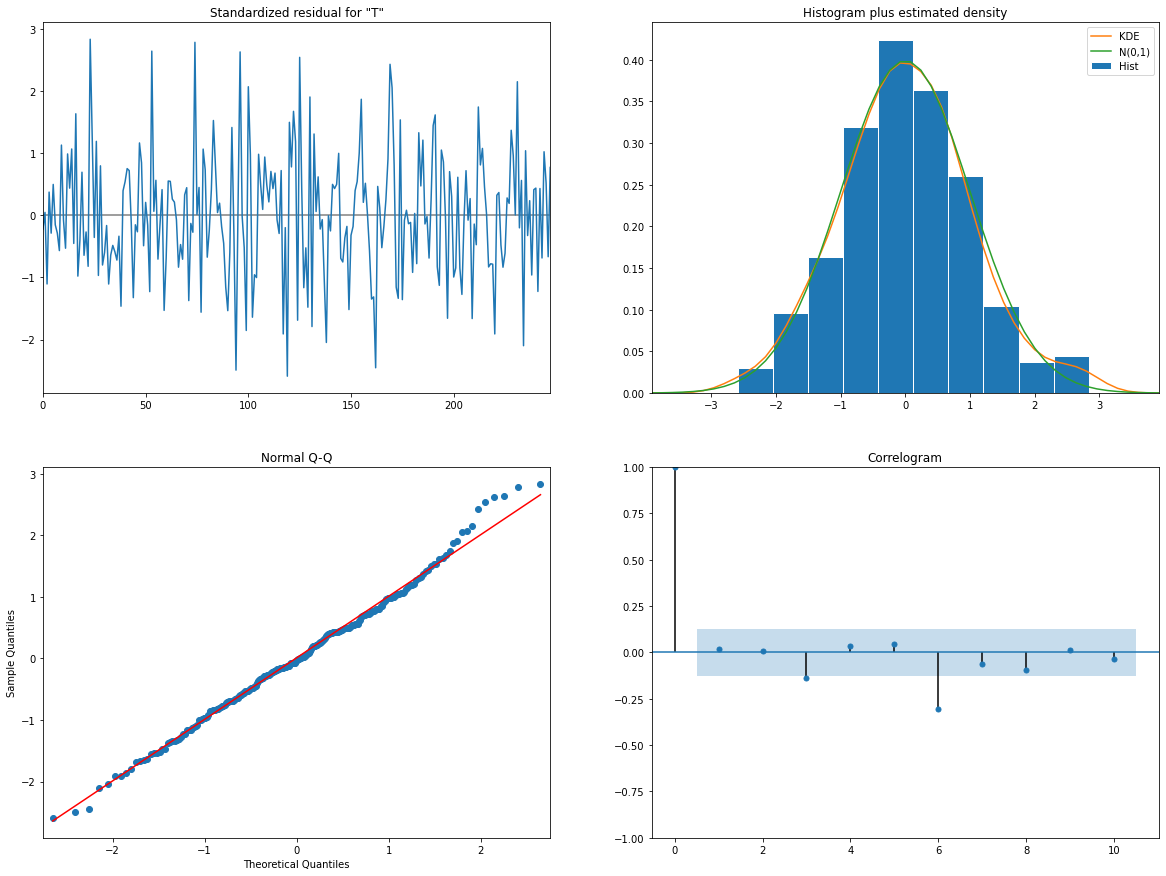

In [320]:
fitted_model.plot_diagnostics(figsize=(20, 15));

In [321]:
PRED = fitted_model.forecast(12)
PRED

301    12.822346
302    12.051334
303    10.304178
304     8.481514
305     7.580614
306     6.408734
307     5.485123
308     3.596637
309     3.231252
310     3.121758
311     3.237479
312     2.878435
Name: predicted_mean, dtype: float64

In [322]:
PRED = PRED.drop(PRED.index[:1])

In [323]:
PRED

302    12.051334
303    10.304178
304     8.481514
305     7.580614
306     6.408734
307     5.485123
308     3.596637
309     3.231252
310     3.121758
311     3.237479
312     2.878435
Name: predicted_mean, dtype: float64

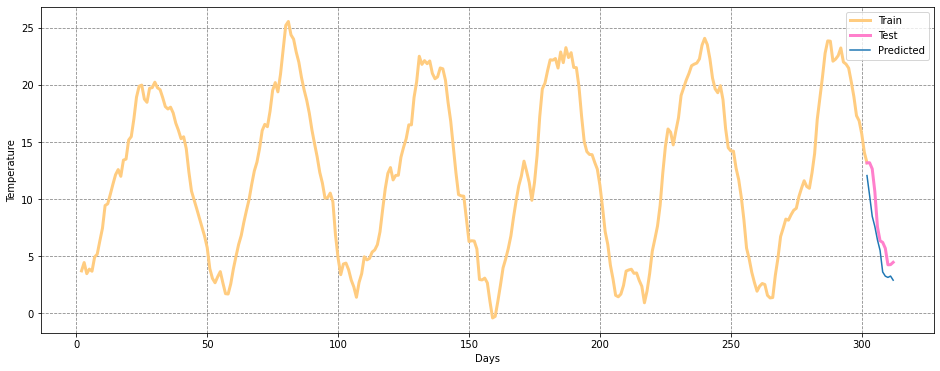

In [324]:
fig, ax1 = plt.subplots(1, 1, figsize=(16, 6))

train.plot(ax = ax1, color = "#FFCC80", lw = 3, label = "Train")
test.plot(ax = ax1, color = "#FF80CC", lw = 3, label = "Test")
#prediction["mean"][80:271].plot(ax = ax1, color = "#3050BB", lw = 1, label = "In-Sample Prediction") # Next point in-sample prediction
plt.plot(PRED,label="Predicted")
plt.legend(loc = 'Left corner')

ax1.set_xlabel("Days"); ax1.set_ylabel("Temperature"); plt.legend()
ax1.grid(True, axis='both', color='#888888', linestyle='--')

In [325]:
def RMSE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(np.mean(np.abs((y_true - y_pred) / y_true)))

In [326]:
RMSE(test, PRED)

0.513890373863348

In [327]:
PRED

302    12.051334
303    10.304178
304     8.481514
305     7.580614
306     6.408734
307     5.485123
308     3.596637
309     3.231252
310     3.121758
311     3.237479
312     2.878435
Name: predicted_mean, dtype: float64

In [328]:
test

302    13.167489
303    13.175756
304    12.641988
305    10.637549
306     7.553580
307     6.333859
308     6.192714
309     5.674575
310     4.226643
311     4.240064
312     4.445588
Name: Temperature, dtype: float64